# Test Wavelet Analysis

With pressure sensor parascientific and new sensor 

In [187]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from andbro__savefig import __savefig

In [188]:
from functions.get_theoretical_backazimuth import __get_theoretical_backazimuth
from functions.request_data import __request_data
from functions.compute_adr_pfo import __compute_adr_pfo

In [189]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [190]:
config = {}

## BSPF coordinates
config['BSPF_lon'] = -116.455439
config['BSPF_lat'] = 33.610643

##
config['path_to_mseed'] = data_path+"BSPF/data/waveforms/ACC/"

## event selction
config['path_to_data'] = data_path+"BSPF/data/"

## output path for figures
config['output_figs'] = data_path+"BSPF/figures/xwt/"


In [191]:
events = obs.read_events(config['path_to_data']+"catalogs/BSPF_catalog_20221001_20230615_all.xml")

triggered = pd.read_pickle(config['path_to_data']+"catalogs/BSPF_catalog_20221001_20230615_triggered.pkl")

event_times = pd.read_pickle(config['path_to_data']+"event_selection_good.pkl")

## Event Info

## Load Data

In [192]:
num = 1

event_time = event_times.origin_time.loc[num]

event = events.filter(f"time >= {event_time}",f"time <= {event_time}")

trig = triggered[triggered.origin == event_time]

## prepare string
event_time_str = event_time.split(".")[0].replace(" ","_").replace("-","").replace(":","")

In [193]:
config['fmin'], config['fmax'] = 1, 18

In [194]:
st = obs.read(config['path_to_mseed']+f"*{event_time_str}*")

st.resample(40).trim(st[0].stats.starttime, st[0].stats.endtime);

st.detrend("linear");

# st.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True);

In [195]:
cut_offs = [
    (70,60), (65,80), (60,100), (60,100), (60,70),
    (60,90), (60,90), (60,90), (62,105), (65,90),
    (62,110), (65,85), (60,105), (63,105), (66,90),
    (60,90), (65,90), (70,95),
]

# st.trim(st[0].stats.starttime+cut_offs[num][0]-10, st[0].stats.endtime-cut_offs[num][1]+10);
st.trim(st[0].stats.starttime+cut_offs[num][0], st[0].stats.endtime-cut_offs[num][1]);

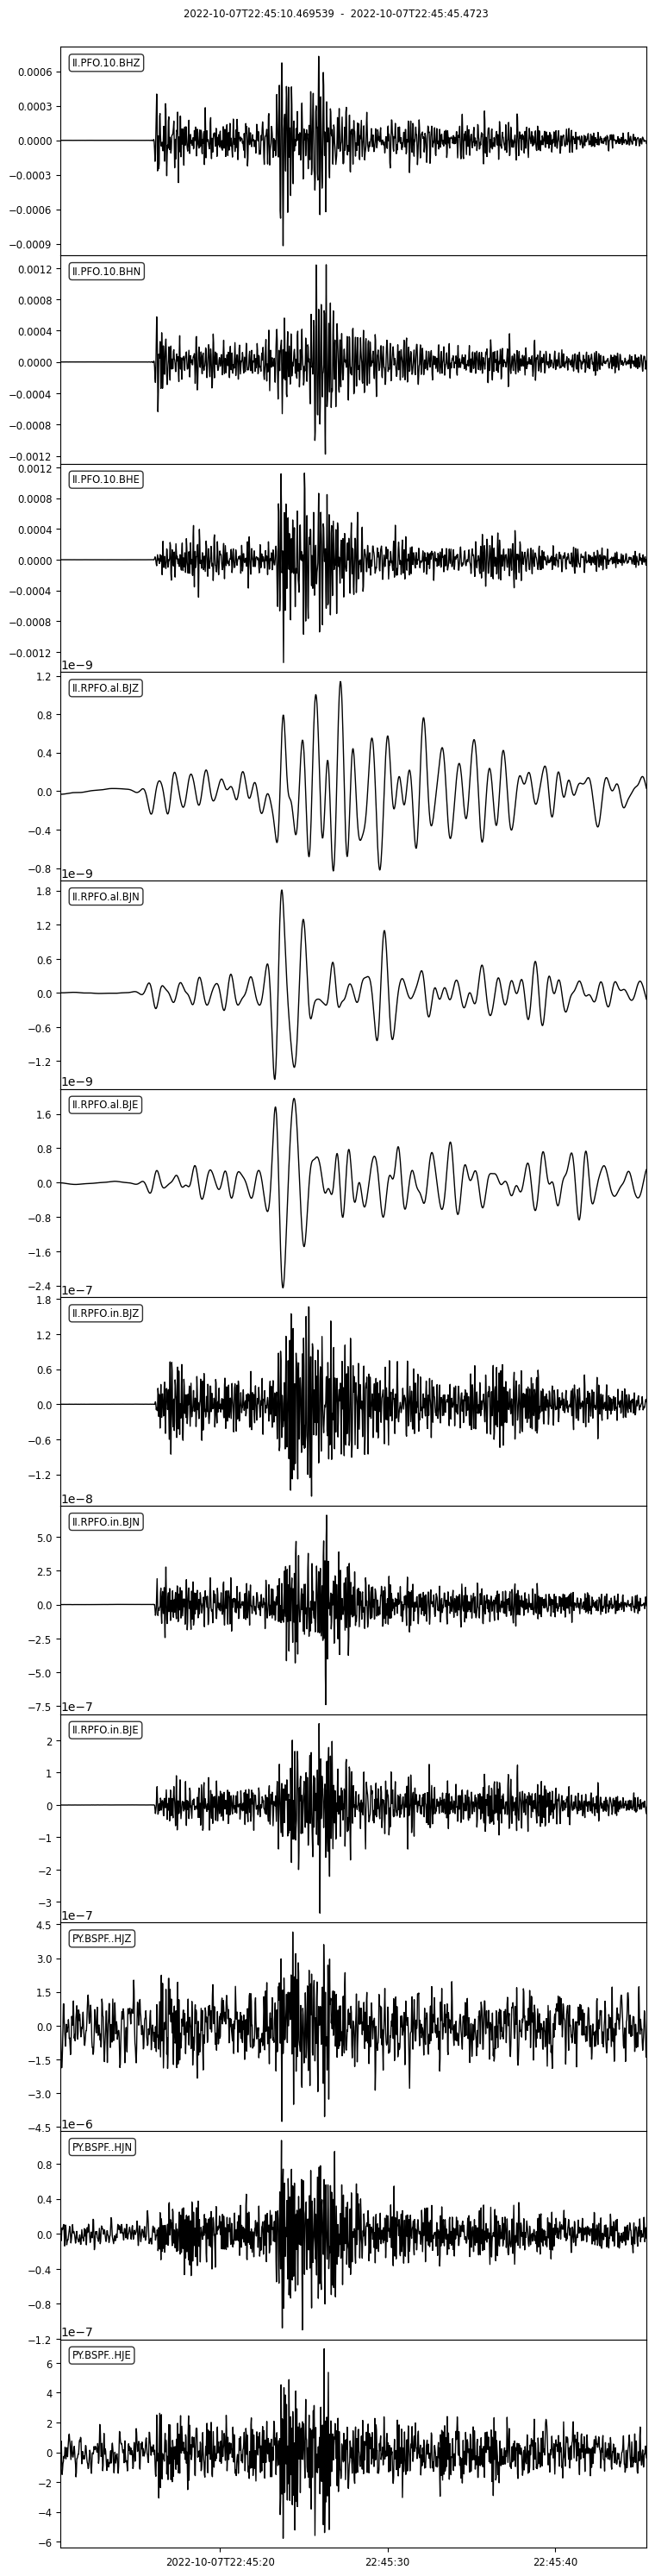

In [196]:
st.plot(equal_scale=False);

In [197]:
from functions.makeplotStream_spectra import __makeplotStreamSpectra

Hanning window applied 

Hanning window applied 

Hanning window applied 

Hanning window applied 

Hanning window applied 

Hanning window applied 

Hanning window applied 

Hanning window applied 

Hanning window applied 

Hanning window applied 

Hanning window applied 

Hanning window applied 



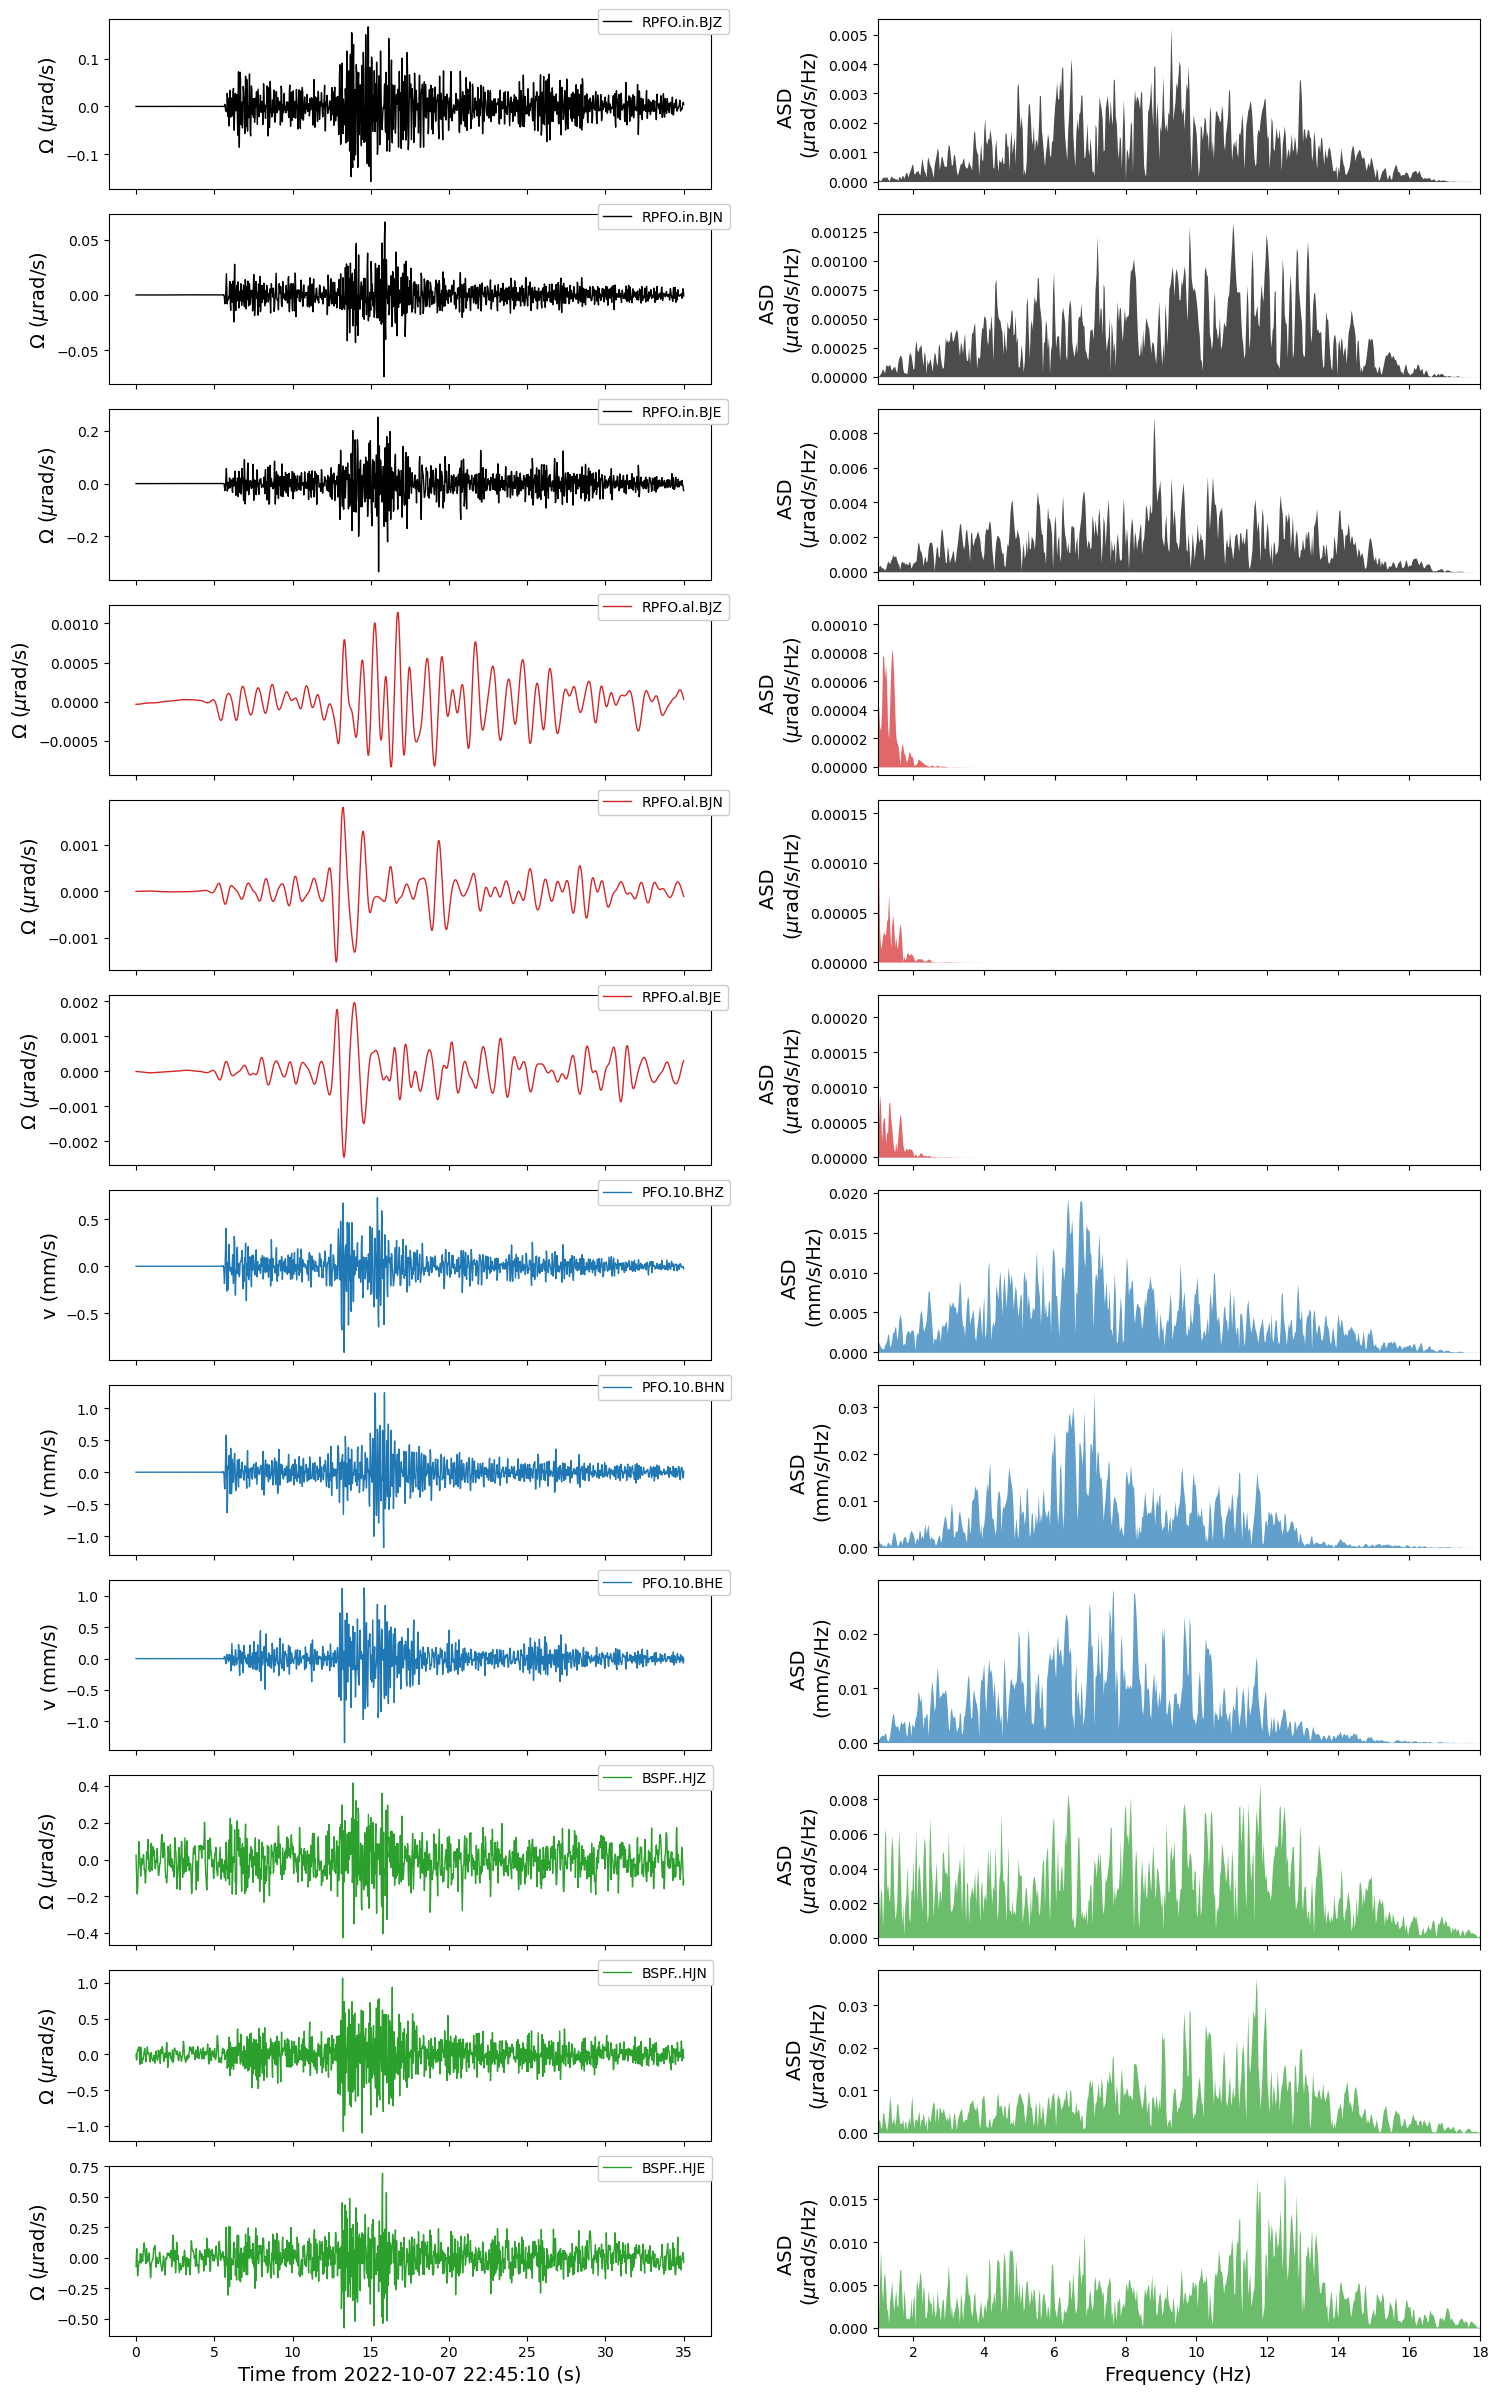

In [198]:
fig = __makeplotStreamSpectra(st, fmin=config['fmin'], fmax=config['fmax'], fscale="linlin");

### Plot CWT

In [199]:
from functions.makeplotStream_cwt import __makeplotStream_cwt

In [200]:
# fig = __makeplotStream_cwt(st, config);

In [201]:
# __savefig(fig, "/home/andbro/Documents/LMU_Docs/EGU2023/", "CWT_All", mode="png", dpi=600)

In [205]:
py_z = st.copy().select(station="BSPF", channel="*Z")
ad_z = st.copy().select(station="RPFO", location="in", channel="*Z")

## Wavelt Coherency Transform 

Calculating wavelet coherence significance


100%|███████████████████████████████████████████████████| 300/300 [04:02<00:00,  1.23it/s]
/tmp/ipykernel_1486900/2180553890.py:117: RuntimeWarning: Mean of empty slice
  global_power_f = nan_to_num(nanmean(wct_power_masked,axis=1), nan=0)
/tmp/ipykernel_1486900/2180553890.py:118: RuntimeWarning: Mean of empty slice
  global_power_t = nan_to_num(nanmean(wct_power_masked,axis=0), nan=0)


0.05704011608262724 0.04316902204865948


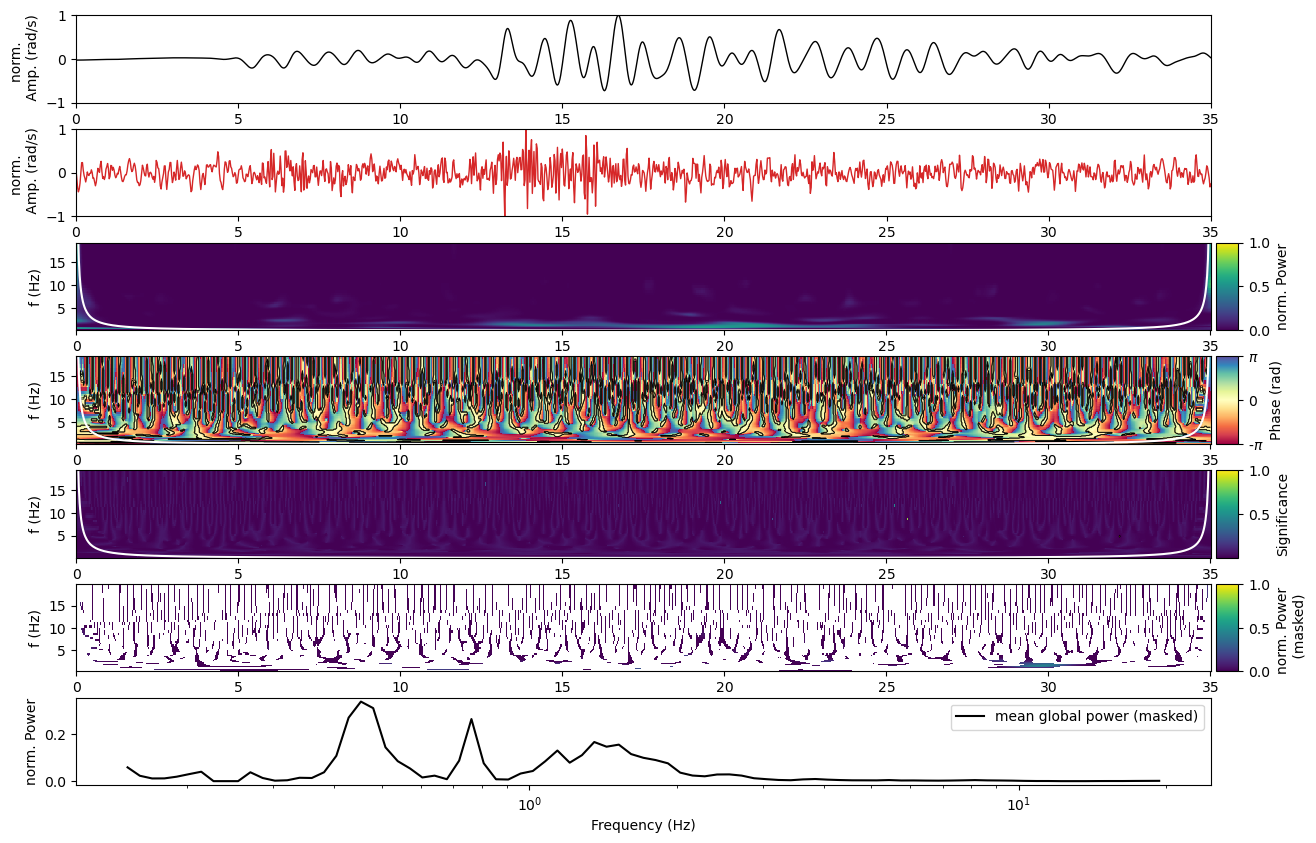

In [206]:
def __compute_wct(times, arr1, arr2, tdelta, normalize=True, plot=True):

    from pycwt import wct, xwt, Morlet, ar1, significance
    from numpy import std, nanmean, nan, nanmax, nanmin, nanvar, ones, nan_to_num, zeros

    if len(arr1) != len(arr1):
        print(" -> different lenght of arrays!")
        return

    def __mask_cone(arr2d, ff, thresholds, fill=nan):
        mask = ones(arr2d.shape)
        for k in range(arr2d.shape[0]):  ##85
            for l in range(arr2d.shape[1]):  ## 1401
                 if ff[k] < thresholds[l]:
                    mask[k,l] = fill
        return mask

    def __mask_smaller_threshold(arr2d, thres, fill=nan):
        mask = ones(arr2d.shape)
        for k in range(arr2d.shape[0]):
            for l in range(arr2d.shape[1]):
                if arr2d[k,l] < thres:
                    mask[k,l] = fill
        return mask

    def __mask_bigger_threshold(arr2d, thres, fill=nan):
        mask = ones(arr2d.shape)
        for k in range(arr2d.shape[0]):
            for l in range(arr2d.shape[1]):
                if arr2d[k,l] > thres:
                    arr2d[k,l], mask[k,l] = fill
        return mask

    def __mask_unequal_threshold(arr2d, thres, fill=nan, tolerance=0):
        mask = ones(arr2d.shape)
        for k in range(arr2d.shape[0]):
            for l in range(arr2d.shape[1]):
                if arr2d[k,l] < (thres-tolerance) or arr2d[k,l] > (thres+tolerance):
                    mask[k,l] = fill
        return mask

    ## specify parameters
    N = len(arr1)
    dt = tdelta
    df = 1/dt
    significance_threshold = 0.95

    ## normalize, if desired
    if normalize:
        arr1 /= nanmax(abs(arr1))
        arr2 /= nanmax(abs(arr2))

    ## create mother wavelet
    mother_wavelet = Morlet(6)
    s0_set = 2 * dt  # Starting scale
    dj_set = 1 / 12  # Twelve sub-octaves per octaves
    J_set = int(7 / dj_set)  # Seven powers of two with dj sub-octaves
    #print(s0_set, dj_set, J_set)

    ## compute variance of array
    variance1 = nanvar(arr1)
    variance2 = nanvar(arr2)

    wave_wct, phases, cone_p, ff_wct, sig = wct(
    # wave_wct, scales, coi, ff_wct, fftfreqs = wct(
                                                arr1,
                                                arr2,
                                                dt=dt,
                                                dj=dj_set,
                                                s0=s0_set,
                                                sig=True,
                                                J=J_set,
                                                significance_level=significance_threshold,
                                                wavelet=mother_wavelet,
                                                normalize=normalize,
                                            )
    cone_f = 1/cone_p

    ## building cone
    mask_cone = __mask_cone(wave_wct, ff_wct, cone_f, fill=nan)

    ## compute absolute power
    wct_power = abs(wave_wct)**2

    print(variance1, variance2)
    ## Lag-1 autocorrelation for red noise
    alpha, _, _ = ar1(arr1)

    ## compute significance test
    signif, theor_red_noise_fft = significance(
                                                variance1,
                                                dt,
                                                phases,
                                                sigma_test=0,
                                                alpha=alpha,
                                                significance_level=significance_threshold,
                                                dof=-1,
                                                wavelet=mother_wavelet,
                                                )

    signif /= nanmax(signif.reshape((1,signif.size))[0])

    ## replace values below threshold with nan values
    mask_signif = __mask_smaller_threshold(signif, significance_threshold, fill=nan)

    ## filter phases with threshold
    phase_threshold = 0
    phase_tolerance = 0.5
    mask_phases = __mask_unequal_threshold(phases, phase_threshold, fill=nan, tolerance=phase_tolerance)
    # phases = __filter_smaller_threshold(phases, 3., fill=nan)


    ## filter power
    wct_power_masked = wct_power * mask_phases * mask_cone

    ## compute global power along both axes
    global_power_f = nan_to_num(nanmean(wct_power_masked,axis=1), nan=0)
    global_power_t = nan_to_num(nanmean(wct_power_masked,axis=0), nan=0)



    ## ____________________________________________________
    ## plotting
    if plot:

        from mpl_toolkits.axes_grid1 import make_axes_locatable

        N = 7

        fig, ax = plt.subplots(N, 1, figsize=(15,10))

        caxs = []

        plt.subplots_adjust(hspace=0.3)

        ax[0].plot(times, arr1, alpha=1, color="black", lw=1)
        ax[0].set_xlim(min(times), max(times))
        ax[0].set_ylim(-1,1)
        ax[0].set_ylabel("norm. \n Amp. (rad/s)")

        ax[1].plot(times, arr2, alpha=1, color="tab:red", lw=1)
        ax[1].set_xlim(min(times), max(times))
        ax[1].set_ylim(-1,1)
        ax[1].set_ylabel("norm. \n Amp. (rad/s)")

        ca2 = ax[2].pcolormesh(times, ff_wct, wct_power, vmin=0, vmax=1)
        ax[2].set_ylabel("f (Hz)")
        ax[2].plot(times, cone_f, color="white")
        ax[2].set_ylim(min(ff_wct), max(ff_wct))

        ca3 = ax[3].pcolormesh(times, ff_wct, phases, cmap="Spectral", vmin=-np.pi, vmax=np.pi)
        # cs = ax[3].contourf(times, ff_wct, mask_phases, cmap="binary_r", vmin=0, vmax=1)
        ax[3].contour(times, ff_wct, nan_to_num(mask_phases), linewidths=0.5, colors="k", levels=1)
        ax[3].set_ylabel("f (Hz)")
        ax[3].plot(times, cone_f, color="white")
        ax[3].set_ylim(min(ff_wct), max(ff_wct))

        ca4 = ax[4].pcolormesh(times, ff_wct, signif)
        ax[4].contour(times, ff_wct, nan_to_num(mask_signif), linewidths=0.3, colors="k", levels=1)
        ax[4].set_ylabel("f (Hz)")
        ax[4].plot(times, cone_f, color="white")
        ax[4].set_ylim(min(ff_wct), max(ff_wct))

        ca5 = ax[5].pcolormesh(times, ff_wct, wct_power_masked, vmin=0, vmax=1)
        ax[5].set_ylabel("f (Hz)")

        ax[6].plot(ff_wct, global_power_f, color="black", label="mean global power (masked)")
        ax[6].legend()
        ax[6].set_ylabel("norm. Power")
        ax[6].set_xlabel("Frequency (Hz)")
        ax[6].set_xscale("log")


        for n in range(N):
            caxs.append(make_axes_locatable(ax[n]).append_axes("right", size="2%", pad=0.05))
        cbar2 = plt.colorbar(ca2, cax=caxs[2], label="norm. Power")
        cbar3 = plt.colorbar(ca3, cax=caxs[3], label="Phase (rad)")
        cbar4 = plt.colorbar(ca4, cax=caxs[4], label="Significance")
        cbar5 = plt.colorbar(ca5, cax=caxs[5], label="norm. Power \n (masked)")
        caxs[0].remove()
        caxs[1].remove()
        caxs[6].remove()

        cbar3.set_ticks([-np.pi, 0, np.pi])
        cbar3.set_ticklabels([r"-$\pi$", "0", "$\pi$"])

        plt.show()

    ## prepare dict for return
    out = {}
    out['times'] = times
    out['frequencies'] = ff_wct
    out['wct_power'] = wct_power
    out['cone_mask'] = mask_cone
    out['phase_mask'] = mask_phases
    out['mean_global_wct'] = global_power_f

    return out

out = __compute_wct( ad_z[0].times(), ad_z[0].data, py_z[0].data, ad_z[0].stats.delta, plot=True )

## Cross Wavlet Transform

/tmp/ipykernel_1486900/124144292.py:90: RuntimeWarning: Mean of empty slice
  global_xwt_f = nanmean(xwt_power_masked, axis=1)


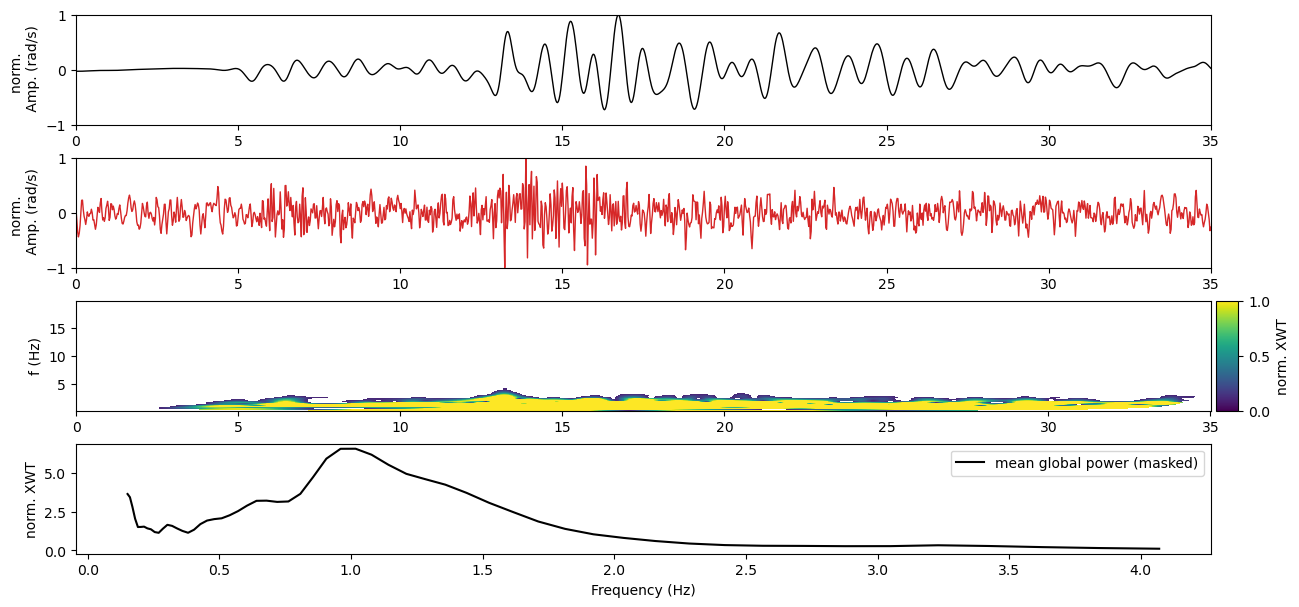

In [207]:
def __compute_xwt(times, arr1, arr2, tdelta, xwt_threshold = 0.1, normalize=True, plot=True):

    from pycwt import wct, xwt, Morlet, ar1, significance
    from numpy import std, nanmean, nan, nanmax, nanmin, nanvar, ones, nan_to_num

    if len(arr1) != len(arr1):
        print(" -> different lenght of arrays!")
        return

    def __mask_cone(arr2d, ff, thresholds, fill=nan):
        mask = ones(arr2d.shape)
        for k in range(arr2d.shape[0]):  ##85
            for l in range(arr2d.shape[1]):  ## 1401
                 if ff[k] < thresholds[l]:
                    mask[k,l] = fill
        return mask

    def __mask_smaller_threshold(arr2d, thres, fill=nan):
        mask = ones(arr2d.shape)
        for k in range(arr2d.shape[0]):
            for l in range(arr2d.shape[1]):
                if arr2d[k,l] < thres:
                    mask[k,l] = fill
        return mask

    def __mask_bigger_threshold(arr2d, thres, fill=nan):
        mask = ones(arr2d.shape)
        for k in range(arr2d.shape[0]):
            for l in range(arr2d.shape[1]):
                if arr2d[k,l] > thres:
                    arr2d[k,l], mask[k,l] = fill
        return mask

    def __mask_unequal_threshold(arr2d, thres, fill=nan, tolerance=0):
        mask = ones(arr2d.shape)
        for k in range(arr2d.shape[0]):
            for l in range(arr2d.shape[1]):
                if arr2d[k,l] < (thres-tolerance) or arr2d[k,l] > (thres+tolerance):
                    mask[k,l] = fill
        return mask

    ## specify parameters
    N = len(arr1)
    dt = tdelta
    df = 1/dt
    significance_threshold = 0.95

    ## normalize, if desired
    if normalize:
        arr1 /= nanmax(abs(arr1))
        arr2 /= nanmax(abs(arr2))

    ## create mother wavelet
    mother_wavelet = Morlet(6)
    s0_set = 2 * dt  # Starting scale
    dj_set = 1 / 12  # Twelve sub-octaves per octaves
    J_set = int(7 / dj_set)  # Seven powers of two with dj sub-octaves
    #print(s0_set, dj_set, J_set)

    ## compute cross-wavelet transform
    xwt, cone_p, ff_xwt, d = xwt(
                                arr1,
                                arr2,
                                dt=dt,
                                dj=dj_set, #0.05,
                                s0=s0_set, #-1,
                                J=J_set, #-1,
                                significance_level=significance_threshold,
                                wavelet=mother_wavelet,  # u'morlet',
                                normalize=normalize,
                               )

    cone_f = 1/cone_p

    ## building cone
    mask_cone = __mask_cone(xwt, ff_xwt, cone_f, fill=nan)


    ## get real part
    xwt_power = abs(xwt)


    ## replace values below threshold with nan values
    # xwt_threshold = 0.1
    mask_xwt = __mask_smaller_threshold(xwt_power, xwt_threshold, fill=nan)

    xwt_power_masked = xwt_power * mask_xwt * mask_cone

    ## compute global cross wavelet transform power
    global_xwt_f = nanmean(xwt_power_masked, axis=1)



    ## ____________________________________________________
    ## plotting
    if plot:

        from mpl_toolkits.axes_grid1 import make_axes_locatable

        N = 4

        fig, ax = plt.subplots(N, 1, figsize=(15,7))

        caxs = []

        plt.subplots_adjust(hspace=0.3)

        ax[0].plot(times, arr1, alpha=1, color="black", lw=1)
        ax[0].set_xlim(min(times), max(times))
        ax[0].set_ylabel("norm. \n Amp. (rad/s)")

        ax[1].plot(times, arr2, alpha=1, color="tab:red", lw=1)
        ax[1].set_xlim(min(times), max(times))
        ax[1].set_ylabel("norm. \n Amp. (rad/s)")

        if normalize:
            ca2 = ax[2].pcolormesh(times, ff_xwt, xwt_power_masked, vmin=0, vmax=1)
        else:
            ca2 = ax[2].pcolormesh(times, ff_xwt, xwt_power)
        # ax[2].plot(times, cone_f, color="white")
        ax[2].set_ylabel("f (Hz)")

        ax[3].plot(ff_xwt, global_xwt_f, color="black", label="mean global power (masked)")
        ax[3].legend()
        ax[3].set_ylabel("norm. XWT")
        ax[3].set_xlabel("Frequency (Hz)")
        # ax[3].set_xscale("log")


        for n in range(N):
            caxs.append(make_axes_locatable(ax[n]).append_axes("right", size="2%", pad=0.05))
        cbar2 = plt.colorbar(ca2, cax=caxs[2], label="norm. XWT")
        caxs[0].remove()
        caxs[1].remove()
        caxs[3].remove()

        if normalize:
            ax[0].set_ylim(-1,1)
            ax[1].set_ylim(-1,1)

        plt.show()

    ## prepare dict for return
    out = {}
    out['times'] = times
    out['frequencies'] = ff_xwt
    out['xwt_power'] = xwt_power
    out['cone_mask'] = mask_cone
    out['xwt_mask'] = mask_xwt
    out['mean_global_xwt'] = global_xwt_f

    return out

out = __compute_xwt( ad_z[0].times(), ad_z[0].data, py_z[0].data, ad_z[0].stats.delta, xwt_threshold=0.1, normalize=True, plot=True )

## Test

In [127]:
def __compute_wavelets(times, arr1, arr2, tdelta, plot=True):

    from pycwt import wct, xwt, Morlet, ar1, significance
    from numpy import std, nanmean, nan, nanmax, nanmin, nanvar, dot, ones

    if len(arr1) != len(arr1):
        print(" -> different lenght of arrays!")
        return

    def __mask_smaller_threshold(arr2d, thres, fill=nan):
        mask = ones(arr2d.shape)
        for k in range(arr2d.shape[0]):
            for l in range(arr2d.shape[1]):
                if arr2d[k,l] < thres:
                    mask[k,l] = fill
        return mask

    def __mask_bigger_threshold(arr2d, thres, fill=nan):
        mask = ones(arr2d.shape)
        for k in range(arr2d.shape[0]):
            for l in range(arr2d.shape[1]):
                if arr2d[k,l] > thres:
                    arr2d[k,l], mask[k,l] = fill
        return mask

    def __mask_unequal_threshold(arr2d, thres, fill=nan):
        mask = ones(arr2d.shape)
        for k in range(arr2d.shape[0]):
            for l in range(arr2d.shape[1]):
                if arr2d[k,l] < (thres-0.5) or arr2d[k,l] > (thres+0.5):
                    mask[k,l] = fill
        return mask

    N = len(arr1)
    dt = tdelta
    df = 1/dt
    significance_threshold = 0.95

    arr1 /= nanmax(abs(arr1))
    arr2 /= nanmax(abs(arr2))

    ## create mother wavelet
    mother_wavelet = Morlet(6)
    s0_set = 2 * dt  # Starting scale
    dj_set = 1 / 12  # Twelve sub-octaves per octaves
    J_set = int(7 / dj_set)  # Seven powers of two with dj sub-octaves
    #print(s0_set, dj_set, J_set)

    ## compute variance of array
    variance1 = nanvar(arr1)
    variance2 = nanvar(arr2)

    wave_wct, phases, cone, ff_wct, sig = wct(
    # wave_wct, scales, coi, ff_wct, fftfreqs = wct(
                                                arr1,
                                                arr2,
                                                dt=dt,
                                                dj=dj_set,
                                                s0=s0_set,
                                                sig=True,
                                                J=J_set,
                                                significance_level=significance_threshold,
                                                wavelet=mother_wavelet,
                                                normalize=True,
                                            )

    ## compute absolute power
    wct_power = abs(wave_wct)**2

    print(variance1, variance2)
    ## Lag-1 autocorrelation for red noise
    alpha, _, _ = ar1(arr1)

    ## compute significance test
    signif, theor_red_noise_fft = significance(
                                                variance1,
                                                dt,
                                                phases,
                                                sigma_test=0,
                                                alpha=alpha,
                                                significance_level=significance_threshold,
                                                dof=-1,
                                                wavelet=mother_wavelet,
                                                )

    signif /= nanmax(signif.reshape((1,signif.size))[0])

    ## replace values below threshold with nan values
    mask_signif = __mask_smaller_threshold(signif, significance_threshold, fill=nan)

    ## filter phases with threshold
    phase_threshold = 0
    mask_phases = __mask_unequal_threshold(phases, phase_threshold, fill=nan)
    # phases = __filter_smaller_threshold(phases, 3., fill=nan)


    ## filter power
    wct_power_masked = wct_power * mask_phases

    ## compute global power along both axes
    global_power_f = nanmean(wct_power_masked,axis=1)
    global_power_t = nanmean(wct_power_masked,axis=0)

    ## compute cross-wavelet transform
    wave_xwt, b, ff_xwt, d = xwt(
                                arr1,
                                arr2,
                                dt=dt,
                                dj=dj_set, #0.05,
                                s0=s0_set, #-1,
                                J=J_set, #-1,
                                significance_level=significance_threshold,
                                wavelet=u'morlet',
                                normalize=True,
                               )
    ## get real part
    wave_xwt_power = abs(wave_xwt)


    ## replace values below threshold with nan values
    xwt_threshold = 0.1
    mask_xwt = __mask_smaller_threshold(wave_xwt_power, xwt_threshold, fill=nan)

    wave_xwt_power_masked = wave_xwt_power * mask_xwt

    ## compute global cross wavelet transform power
    global_xwt_f = nanmean(wave_xwt_power_masked, axis=1)


    print(wave_wct.shape, phases.shape, cone.shape, ff_wct.shape, sig.shape)

    print("signif", nanmax(signif.reshape((1,signif.size))[0]), nanmin(signif.reshape((1,signif.size))[0]))

    print("phases", nanmax(phases.reshape((1,signif.size))[0]), nanmin(phases.reshape((1,signif.size))[0]))


    ## ____________________________________________________
    ## plotting
    if plot:

        from mpl_toolkits.axes_grid1 import make_axes_locatable

        N = 8

        fig, ax = plt.subplots(N, 1, figsize=(15,10))

        caxs = []

        plt.subplots_adjust(hspace=0.3)

        ca1 = ax[0].plot(times, ad_z[0].data, alpha=1, color="black", lw=1)
        ax[0].set_xlim(min(times), max(times))
        ax[0].set_ylim(-1,1)

        ax[1].plot(times, py_z[0].data, alpha=1, color="tab:red", lw=1)

        ax[1].set_xlim(min(times), max(times))
        ax[1].set_ylim(-1,1)

        ca2 = ax[2].pcolormesh(times, ff_xwt, wave_xwt_power_masked)

        ca3 = ax[3].pcolormesh(times, ff_wct, wct_power_masked)

        ca4 = ax[4].pcolormesh(times, ff_wct, phases, cmap="Spectral", vmin=-np.pi, vmax=np.pi)
        # cs = ax[4].contourf(times, ff_wct, mask_phases, cmap="binary_r", vmin=0, vmax=1)
        ax[4].contour(times, ff_wct, np.nan_to_num(mask_phases), linewidths=0.5, colors="k", levels=1)

        ca5 = ax[5].pcolormesh(times, ff_wct, signif)

        ca6 = ax[6].pcolormesh(times, ff_wct, wct_power_masked)

        ca7 = ax[7].plot(ff_wct, global_power_f, color="tab:blue")
        ax7 = ax[7].twinx()
        ax7.plot(ff_xwt, global_xwt_f, color="tab:orange")

        for n in range(N):
            caxs.append(make_axes_locatable(ax[n]).append_axes("right", size="2%", pad=0.05))
        cbar2 = plt.colorbar(ca2, cax=caxs[2])
        cbar3 = plt.colorbar(ca3, cax=caxs[3])
        cbar4 = plt.colorbar(ca4, cax=caxs[4])
        cbar5 = plt.colorbar(ca5, cax=caxs[5])
        cbar6 = plt.colorbar(ca6, cax=caxs[6])
        caxs[0].remove()
        caxs[1].remove()
        caxs[7].remove()

        plt.show()

# __compute_wavelets( ad_z[0].times(), ad_z[0].data, py_z[0].data, ad_z[0].stats.delta, plot=True )

In [21]:
# fig = __makeplotStream_coherence(st_adr, config);

In [22]:
def __makeplotStream_csd(st0, config):

    from scipy import fftpack
    from matplotlib.gridspec import GridSpec
    from scipy.signal import csd
    from numpy import array, log10
    
    import matplotlib.pyplot as plt

    st = st0.copy()
    
    NN = 5
    rot_scaling, rot_unit = 1e6, r"$\mu$rad/s"
    trans_scaling, trans_unit = 1e6, r"$\mu$m/s"
    
#     rot_scaling, rot_unit = 1, r"nrad/s"
#     trans_scaling, trans_unit = 1, r"$\mu$m/s"

    colors = ['crimson', 'red', 'magenta', 'darkblue', '#3776ab', 'indigo']
    colors2 = ['crimson', 'darkblue', 'red', '#3776ab', 'magenta', 'indigo']

    fig = plt.figure(figsize=(15,12))
    
    gs = GridSpec(NN, 2, figure=fig)
    
    ax1 = fig.add_subplot(gs[0, :-1])
    ax2 = fig.add_subplot(gs[1, :-1])
    ax3 = fig.add_subplot(gs[2, :-1])

    ax4 = fig.add_subplot(gs[0, 1:])
    ax5 = fig.add_subplot(gs[1, 1:])
    ax6 = fig.add_subplot(gs[2, 1:])

    ax7 = fig.add_subplot(gs[3:, :])
    
    
    font = 18
    
    plt.subplots_adjust(hspace=0.1)

    ## _______________________________________________

#     st.normalize()
    
    st.sort(keys=['channel'], reverse=True)
        
    names, ffs, csds, ffs2, csds2 = [], [], [], [], []
    for comp in ["Z", "N", "E"]:
        
        tmp = st.select(channel=f"*{comp}")

        print(tmp)
        
        ff, Pxy = csd(  
                        tmp[0].data, 
                        tmp[1].data, 
                        fs=tmp[0].stats.sampling_rate, 
                        nperseg=int(10*tmp[0].stats.sampling_rate),
                        window='hann', 
                        noverlap=75, 
                        nfft=None, 
                        detrend='constant', 
                        return_onesided=True, 
                        scaling='spectrum', 
                        axis=-1, 
                        average='mean'
                    )
        names.append(f"{tmp[0].stats.channel}_inner")
        ffs.append(ff)
        csds.append(Pxy)
        
        ff2, Pxy2 = csd(  
                        tmp[0].data, 
                        tmp[2].data, 
                        fs=tmp[0].stats.sampling_rate, 
                        nperseg=int(10*tmp[0].stats.sampling_rate),
                        window='hann', 
                        noverlap=75, 
                        nfft=None, 
                        detrend='constant', 
                        return_onesided=True, 
                        scaling='spectrum', 
                        axis=-1, 
                        average='mean'
                    )
        
        names.append(f"{tmp[0].stats.channel}_all")
        
        ffs.append(ff2)
        csds.append(Pxy2)

        
    hz = st.select(channel="B*Z")[0]
    hn = st.select(channel="B*N")[0]
    he = st.select(channel="B*E")[0]

    jz = st.select(channel="HJZ")[0]
    jn = st.select(channel="HJN")[0]
    je = st.select(channel="HJE")[0]

    ax1.plot(hz.times(), hz.data*rot_scaling, colors[3], label=f"{hz.stats.station}.{hz.stats.channel}")
    ax2.plot(hn.times(), hn.data*rot_scaling, colors[4], label=f"{hn.stats.station}.{hn.stats.channel}")
    ax3.plot(he.times(), he.data*rot_scaling, colors[5], label=f"{he.stats.station}.{he.stats.channel}")

    ax4.plot(jz.times(), jz.data*rot_scaling, colors[3], label=f"{jz.stats.station}.{jz.stats.channel}")
    ax5.plot(jn.times(), jn.data*rot_scaling, colors[4], label=f"{jn.stats.station}.{jn.stats.channel}")
    ax6.plot(je.times(), je.data*rot_scaling, colors[5], label=f"{je.stats.station}.{je.stats.channel}")

    
    for ii, (ff, cc, name) in enumerate(zip(ffs, csds, names)):
        ax7.plot(ff, 20*log10(abs(cc)/1e-9), label=name[2:], alpha=0.6, color=colors2[ii])
#         ax7.plot(ff, abs(cc)*1e9, label=name[-1], alpha=0.6, color=colors[ii+3])
        

    ax7.set_xscale("log")
#     ax7.set_yscale("log")
    
    for ax in [ax1, ax2, ax3, ax4 ,ax5, ax6]:
        ax.legend(loc=1, fontsize=font-2)
        ax.set_ylabel(f"$\omega$ ({rot_unit})", fontsize=font)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        if ax not in [ax3, ax6]:
            ax.set(xticklabels=[]) 
            ax.tick_params(bottom=False)  
        
    ax7.grid(which="both", ls=":", alpha=0.7, color="grey")
    ax7.legend(fontsize=font-2, ncol=3)
    ax7.set_xlim(0.1, 20)
    
    ax3.set_xlabel("Time (s)", fontsize=font)
    ax6.set_xlabel("Time (s)", fontsize=font)

    ax7.set_xlabel("Frequency (Hz)", fontsize=font)
    ax7.set_ylabel(f"Cross Spectral Density \n (dB rel. to 1 nrad$^2$/s$^2$/Hz)", fontsize=font)
    
    bbox = list(ax7.get_position().bounds)
    bbox[3] = .85*bbox[3] # Reduce the height of the axis a bit.
    ax7.set_position(bbox)
    
    for ax in [ax1, ax2, ax3, ax4 ,ax5, ax6, ax7]:
        ax.tick_params(axis="y", labelsize=15)
        ax.tick_params(axis="x", labelsize=15)
            
#     axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#     axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    return fig

In [23]:
# fig = __makeplotStream_csd(st_adr, config)

In [24]:
def __makeplotStream_csd2(st0, config):

    from scipy import fftpack
    from matplotlib.gridspec import GridSpec
    from scipy.signal import csd
    from numpy import array, log10
    
    import matplotlib.pyplot as plt

    st = st0.copy()
    
    NN = 5
    rot_scaling, rot_unit = 1e6, r"$\mu$rad/s"
    trans_scaling, trans_unit = 1e6, r"$\mu$m/s"
    
#     rot_scaling, rot_unit = 1, r"nrad/s"
#     trans_scaling, trans_unit = 1, r"$\mu$m/s"

    colors = ['crimson', 'red', 'magenta', 'darkblue', '#3776ab', 'indigo']
    colors2 = ['crimson', 'darkblue', 'red', '#3776ab', 'magenta', 'indigo']

    fig = plt.figure(figsize=(15,14))
    
    gs = GridSpec(NN, 2, figure=fig)
    
    ax1 = fig.add_subplot(gs[0, :-1])
    ax2 = fig.add_subplot(gs[1, :-1])
    ax3 = fig.add_subplot(gs[2, :-1])

    ax4 = fig.add_subplot(gs[0, 1:])
    ax5 = fig.add_subplot(gs[1, 1:])
    ax6 = fig.add_subplot(gs[2, 1:])

    ax7 = fig.add_subplot(gs[3:, :])
    
    
    font = 18
    
    plt.subplots_adjust(hspace=0.1)

    ## _______________________________________________

#     st.normalize()
    
    st.sort(keys=['channel'], reverse=True)
        
    bspf_all_data, bspf_inner_data, adr_all_data, adr_inner_data = [],[],[],[] 
    names, ffs, csds, ffs2, csds2 = [], [], [], [], []
    for comp in ["Z", "N", "E"]:
                
        tmp = st.select(channel=f"*{comp}")
        print(tmp)

        bspf_inner = tmp[0].copy()
        bspf_inner.taper(0.1)
        bspf_inner.filter("bandpass", freqmin=1, freqmax=10, corners=4, zerophase=True)
        
        adr_inner = tmp[1].copy()
        adr_inner.taper(0.1)
        adr_inner.filter("bandpass", freqmin=1, freqmax=10, corners=4, zerophase=True)
        
        nseg = int(20*tmp[0].stats.sampling_rate)
        
        ff, Pxy = csd(  
                        bspf_inner.data, 
                        adr_inner.data, 
                        fs=bspf_inner.stats.sampling_rate, 
                        nperseg=nseg,
                        window='hann', 
                        noverlap=int(0.75*nseg), 
                        nfft=None, 
                        detrend='constant', 
                        return_onesided=True, 
                        scaling='density', 
                        axis=-1, 
                        average='mean'
                    )
        names.append(f"{tmp[0].stats.channel}"+r"$_{inner}$")
        ffs.append(ff)
        csds.append(Pxy)

        adr_inner_data.append(adr_inner.data)
        bspf_inner_data.append(bspf_inner.data)
        
        ## _____________________________________
        
        bspf_all = tmp[0].copy()
        bspf_all.taper(0.1)
        bspf_all.filter("bandpass", freqmin=0.15, freqmax=1.2, corners=4, zerophase=True)
        
        adr_all = tmp[2].copy()
        adr_all.taper(0.1)
        adr_all.filter("bandpass", freqmin=0.15, freqmax=1.2, corners=4, zerophase=True)
                
        nseg = int(20*tmp[0].stats.sampling_rate)
        
        ff2, Pxy2 = csd(  
                        bspf_all.data, 
                        adr_all.data, 
                        fs=bspf_all.stats.sampling_rate, 
                        nperseg=nseg,
                        window='hann', 
                        noverlap=int(0.75*nseg), 
                        nfft=None, 
                        detrend='constant', 
                        return_onesided=True, 
                        scaling='density', 
                        axis=-1, 
                        average='mean'
                    )
        
        names.append(f"{tmp[0].stats.channel}"+r"$_{outer}$")
        
        ffs.append(ff2)
        csds.append(Pxy2)
        
        adr_all_data.append(adr_all.data)
        bspf_all_data.append(bspf_all.data)
        
    hz = st.select(channel="B*Z")[0]
    hn = st.select(channel="B*N")[0]
    he = st.select(channel="B*E")[0]

    jz = st.select(channel="HJZ")[0]
    jn = st.select(channel="HJN")[0]
    je = st.select(channel="HJE")[0]

    ax1.plot(hz.times(), bspf_all_data[0]*rot_scaling, 'black', label=f"BSPF.Z")
    ax2.plot(hn.times(), bspf_all_data[1]*rot_scaling, 'black', label=f"BSPF.N")
    ax3.plot(he.times(), bspf_all_data[2]*rot_scaling, 'black', label=f"BSPF.E")
    ax1.plot(hz.times(), adr_all_data[0]*rot_scaling, 'darkred', label=r"ADR$_{outer}$.Z")
    ax2.plot(hn.times(), adr_all_data[1]*rot_scaling, 'darkred', label=r"ADR$_{outer}$.N")
    ax3.plot(he.times(), adr_all_data[2]*rot_scaling, 'darkred', label=r"ADR$_{outer}$.E")

    ax4.plot(jz.times(), bspf_inner_data[0]*rot_scaling, 'black', label=f"BSPF.Z")
    ax5.plot(jn.times(), bspf_inner_data[1]*rot_scaling, 'black', label=f"BSPF.N")
    ax6.plot(je.times(), bspf_inner_data[2]*rot_scaling, 'black', label=f"BSPF.E")
    ax4.plot(jz.times(), adr_inner_data[0]*rot_scaling, 'darkred', label=r"ADR$_{inner}$.Z")
    ax5.plot(jn.times(), adr_inner_data[1]*rot_scaling, 'darkred', label=r"ADR$_{inner}$.N")
    ax6.plot(je.times(), adr_inner_data[2]*rot_scaling, 'darkred', label=r"ADR$_{inner}$.E")

    
    for ii, (ff, cc, name) in enumerate(zip(ffs, csds, names)):
        ax7.plot(ff, 20*log10(abs(cc)/1e-9), label=name[2:], alpha=0.6, color=colors2[ii])
#         ax7.plot(ff, abs(cc)*1e9, label=name[-1], alpha=0.6, color=colors[ii+3])
        

    ax7.set_xscale("log")
#     ax7.set_yscale("log")
    
    for ax in [ax1, ax2, ax3, ax4 ,ax5, ax6]:
        ax.legend(loc=1, fontsize=font-3, bbox_to_anchor=(0.95, 1.10))
        ax.set_ylabel(f"$\omega$ ({rot_unit})", fontsize=font)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        if ax not in [ax3, ax6]:
            ax.set(xticklabels=[]) 
            ax.tick_params(bottom=False)  
        
    ax7.grid(which="both", ls=":", alpha=0.7, color="grey")
    ax7.legend(fontsize=font-2, ncol=3)
    ax7.set_xlim(0.1, 20)
    
    ax3.set_xlabel("Time (s)", fontsize=font)
    ax6.set_xlabel("Time (s)", fontsize=font)

    ax7.set_xlabel("Frequency (Hz)", fontsize=font)
    ax7.set_ylabel(f"Cross Spectral Density \n (dB rel. to 1 nrad$^2$/s$^2$/Hz)", fontsize=font)
    
    bbox = list(ax7.get_position().bounds)
    bbox[3] = .85*bbox[3] # Reduce the height of the axis a bit.
    ax7.set_position(bbox)
    
    for ax in [ax1, ax2, ax3, ax4 ,ax5, ax6, ax7]:
        ax.tick_params(axis="y", labelsize=15)
        ax.tick_params(axis="x", labelsize=15)
            
#     axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#     axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    return fig

In [25]:
fig = __makeplotStream_csd2(st_adr, config)

NameError: name 'st_adr' is not defined

In [ ]:
# __savefig(fig, "/home/andbro/Documents/LMU_Docs/EGU2023/", "ADR_ALL_CSP", mode="png", dpi=600)

## Plot Wavelet Coherence Transform (WCT) and  Cross Wavelet Transform (XWT)

In [ ]:
from pycwt import xwt, wct, significance

In [ ]:
def __makeplotStream_csd(st0, config):

    from scipy import fftpack
    from matplotlib.gridspec import GridSpec
    from scipy.signal import csd
    from numpy import array
    from pycwt import xwt, wct, significance

    import matplotlib.pyplot as plt

    st = st0.copy()

    NN = 5
    rot_scaling, rot_unit = 1e9, r"nrad/s"
    trans_scaling, trans_unit = 1e6, r"$\mu$m/s"

    rot_scaling, rot_unit = 1, r"nrad/s"
    trans_scaling, trans_unit = 1, r"$\mu$m/s"

    colors = ['crimson', 'red', 'magenta', 'darkblue', '#3776ab', 'indigo']

    fig = plt.figure(figsize=(15,12))
    
    gs = GridSpec(NN, 2, figure=fig)
    
    ax1 = fig.add_subplot(gs[0, :-1])
    ax2 = fig.add_subplot(gs[1, :-1])
    ax3 = fig.add_subplot(gs[2, :-1])

    ax4 = fig.add_subplot(gs[0, 1:])
    ax5 = fig.add_subplot(gs[1, 1:])
    ax6 = fig.add_subplot(gs[2, 1:])

    ax7 = fig.add_subplot(gs[3:, :])
    
    
    font = 14
    
    plt.subplots_adjust(hspace=0.1)

    ## _______________________________________________

#     st.normalize()
    
    st.sort(keys=['channel'], reverse=True)
        
    names, ffs_cwt, cwts, ffs_xwt, xwts = [], [], [], [], []
    for comp in ["Z", "N", "E"]:
        
        tmp = st.select(channel=f"*{comp}")

        wave_cwt, scale, coi, ff_cwt, fftfreqs  = wct( 
                                                        tmp[0].data, 
                                                        tmp[1].data, 
                                                        dt=tmp[0].stats.delta, 
                                                        dj=0.1,
                                                        s0=-1,
                                                        J=-1,
                                                        significance_level=0.95,
                                                        wavelet='morlet',
                                                        normalize=True
                                                    )
        
        wave_xwt,b,ff_xwt,d = xwt(
                                    tmp[0].data, 
                                    tmp[1].data, 
                                    dt=tmp[0].stats.delta, 
                                    dj=0.1, 
                                    s0=-1, 
                                    J=-1, 
                                    significance_level=0.95, 
                                    wavelet='morlet', 
                                    normalize=True
                                   )
        
        names.append(f"{tmp[0].stats.channel}")
        ffs_cwt.append(ff_cwt)
        cwts.append(abs(wave_cwt).mean(axis=1))
        ffs_xwt.append(ff_xwt)
        xwts.append(abs(wave_xwt).mean(axis=1))

        
    hz = st.select(channel="B*Z")[0]
    hn = st.select(channel="B*N")[0]
    he = st.select(channel="B*E")[0]

    jz = st.select(channel="HJZ")[0]
    jn = st.select(channel="HJN")[0]
    je = st.select(channel="HJE")[0]

    ax1.plot(hz.times(), hz.data*trans_scaling, colors[3], label=f"{hz.stats.station}.{hz.stats.channel}")
    ax2.plot(hn.times(), hn.data*trans_scaling, colors[4], label=f"{hn.stats.station}.{hn.stats.channel}")
    ax3.plot(he.times(), he.data*trans_scaling, colors[5], label=f"{he.stats.station}.{he.stats.channel}")

    ax4.plot(jz.times(), jz.data*rot_scaling, colors[3], label=f"{jz.stats.station}.{jz.stats.channel}")
    ax5.plot(jn.times(), jn.data*rot_scaling, colors[4], label=f"{jn.stats.station}.{jn.stats.channel}")
    ax6.plot(je.times(), je.data*rot_scaling, colors[5], label=f"{je.stats.station}.{je.stats.channel}")

    ax8 = ax7.twinx()

    for ii, (ff_cwt, cwt, ff_xwt, xwt, name) in enumerate(zip(ffs_cwt, cwts, ffs_xwt, xwts, names)):
        ax7.plot(ff_cwt, cwt, label=name[-1], alpha=0.8, color=colors[ii+3])
        
        ax8.plot(ff_xwt, xwt, label=name[-1], alpha=0.8, color=colors[ii])
        

    ax7.set_xscale("log")
    ax7.set_yscale("log")
    ax8.set_yscale("log")
    
    for ax in [ax1, ax2, ax3, ax4 ,ax5, ax6]:
        ax.legend(loc=1, fontsize=font-2)
        ax.set_ylim(-1,1)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        if ax not in [ax3, ax6]:
            ax.set(xticklabels=[]) 
            ax.tick_params(bottom=False)  
        

    ax7.legend(loc=4, fontsize=font-2)
    ax8.legend(loc=1, fontsize=font-2)

    ax3.set_xlabel("Time (s)", fontsize=font)
    ax6.set_xlabel("Time (s)", fontsize=font)

    ax7.set_xlabel("Frequency (Hz)", fontsize=font)
    ax7.set_ylabel("Wavlet Coherence Transform", fontsize=font)
    ax8.set_ylabel("Cross Wavlet Transform", fontsize=font, color="darkred")
    
    bbox = list(ax7.get_position().bounds)
    bbox[3] = .9*bbox[3] # Reduce the height of the axis a bit.
    ax7.set_position(bbox)
    
#     axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#     axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    return fig

In [ ]:
st_adr2 = st_adr.copy()
st_adr2.normalize()

fig = __makeplotStream_csd(st_adr2, config)

In [ ]:
from functions.compute_cc_for_fbands import __compute_cc_for_fbands

In [ ]:
st_adr_cc = obs.Stream()

st_adr_cc += py_bspf.copy()
st_adr_cc += adr_inner.copy()
# st_adr_cc += py_bspf.copy()

st_adr_cc.filter("bandpass", freqmin=0.2, freqmax=5.0, corners=8, zerophase=True)
st_adr_cc.trim(adr_inner[0].stats.starttime, adr_inner[0].stats.endtime)

In [ ]:
def __makeplotStream_cc(st0, config):

    from scipy import fftpack
    from andbro__fft import __fft
    from matplotlib.gridspec import GridSpec
    from numpy import array
    
    import matplotlib.pyplot as plt

    st = st0.copy()
    
    NN = 5
    rot_scaling, rot_unit = 1e9, r"nrad/s"
    trans_scaling, trans_unit = 1e6, r"$\mu$m/s"
    
#     rot_scaling, rot_unit = 1, r"nrad/s"
#     trans_scaling, trans_unit = 1, r"$\mu$m/s"

    colors = ['crimson', 'red', 'magenta', 'darkblue', '#3776ab', 'indigo']

    fig = plt.figure(figsize=(15,12))
    
    gs = GridSpec(NN, 2, figure=fig)
    
    ax1 = fig.add_subplot(gs[0, :-1])
    ax2 = fig.add_subplot(gs[1, :-1])
    ax3 = fig.add_subplot(gs[2, :-1])

    ax4 = fig.add_subplot(gs[0, 1:])
    ax5 = fig.add_subplot(gs[1, 1:])
    ax6 = fig.add_subplot(gs[2, 1:])

    ax7 = fig.add_subplot(gs[3:, :])
    
    
    font = 14
    
    plt.subplots_adjust(hspace=0.1)

    ## _______________________________________________

#     st.normalize()
    
    st.sort(keys=['channel'], reverse=True)
        
    names, ffs, ccs, ccs_max = [], [], [], []
    for comp in ["Z", "N", "E"]:
        
        tmp = st.select(channel=f"*{comp}")

        f_centers, ccorrs, cc_maxs = __compute_cc_for_fbands(tmp[0], tmp[1], 
                                                    fmin=config['fmin'], 
                                                    fmax=config['fmax'], 
                                                    fband_type='octave'
                                                   )
        
        names.append(f"{tmp[0].stats.channel}")
        ffs.append(f_centers)
        ccs.append(ccorrs)
        ccs_max.append(cc_maxs)
        
    hz = st.select(station="BSPF")[0]
    hn = st.select(station="BSPF")[0]
    he = st.select(station="BSPF")[0]

#     jz = st.select(station="RPFO")[0]
#     jn = st.select(station="RPFO")[0]
#     je = st.select(station="RPFO")[0]
    jz = st.select(station="BSPF")[0]
    jn = st.select(station="BSPF")[0]
    je = st.select(station="BSPF")[0]
    
    ax1.plot(hz.times(), hz.data*trans_scaling, colors[3], label=f"{hz.stats.station}.{hz.stats.channel}")
    ax2.plot(hn.times(), hn.data*trans_scaling, colors[4], label=f"{hn.stats.station}.{hn.stats.channel}")
    ax3.plot(he.times(), he.data*trans_scaling, colors[5], label=f"{he.stats.station}.{he.stats.channel}")

    ax4.plot(jz.times(), jz.data*rot_scaling, colors[3], label=f"{jz.stats.station}.{jz.stats.channel}")
    ax5.plot(jn.times(), jn.data*rot_scaling, colors[4], label=f"{jn.stats.station}.{jn.stats.channel}")
    ax6.plot(je.times(), je.data*rot_scaling, colors[5], label=f"{je.stats.station}.{je.stats.channel}")

    for ii, (ff, cc, cc_max, name) in enumerate(zip(ffs, ccs, ccs_max, names)):
        
        ax7.plot(ff, cc, label=name[-1], alpha=0.6, color=colors[ii+3])
        ax7.scatter(ff, cc, alpha=0.6, color=colors[ii+3])
        
        ax7.plot(ff, cc_max, marker='o', alpha=0.6, color=colors[ii+3], ls="--" )
        ax7.scatter(ff, cc_max, marker='o', alpha=0.6, color=colors[ii+3])
        
    ax7.set_xscale("log")
    ax7.set_ylim(-1.1, 1.1)
    
    for ax in [ax1, ax2, ax3, ax4 ,ax5, ax6]:
        ax.legend(loc=1, fontsize=font-2)
#         ax.set_ylim(-1,1)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        if ax not in [ax3, ax6]:
            ax.set(xticklabels=[]) 
            ax.tick_params(bottom=False)  
        
        
#     if "fmin" in config.keys() and "fmax" in config.keys():
#         ax7.set_xlim(config['fmin'], config['fmax'])    
    
    ax7.legend(loc=4, fontsize=font-2)

    ax3.set_xlabel("Time (s)", fontsize=font)
    ax6.set_xlabel("Time (s)", fontsize=font)

    ax7.set_xlabel("Frequency (Hz)", fontsize=font)
    ax7.set_ylabel("Spec. Amplitude ()", fontsize=font)
    ax7.grid(ls=":", which="both", alpha=0.7)
    
    ## Reduce the height of the axis a bit.
    bbox = list(ax7.get_position().bounds)
    bbox[3] = .9*bbox[3] 
    ax7.set_position(bbox)
    
#     axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#     axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    return fig

In [ ]:
fig = __makeplotStream_cc(st_adr_cc, config);